# Parametric density estimation with `iminuit`

In the previous lectures we have discussed how the *likelihood* principle can be applied to define the loss function of *regression* and *classification* tasks, then we have discussed tecniques to model parameters of the statistical distribution describing the *training data*.
For example, in the case of the regression task, we have used linear or polynomial models to predict the *mean* of a normal distribution given some input varables $\vec x$, while for classification we have predicted the probability *p* of a Bernoulli distribution.

In general, however the distributions we deal with when analysing data are more complex than a normal or a Bernoulli distribution and often we are more interested in a direct estimate of the parameters of that distribution, rather than in a model of those parameters based on $\vec x$ (or at least, we would be happy of a measure, already).

Namely, our likelihood function will be simply
$$
\mathcal L = \prod_i p(\vec y_i | \vec \theta)
$$
and, as already discussed for the classification and regression task, we aim at an estimation of the parameters $\theta$ using the maximum likelihood principle
$$
\hat \theta = \mathop{\mathrm{argmax}}_\theta \mathcal L(\theta)
$$

Or, equivalently,
$$
\hat \theta = \mathop{\mathrm{argmin}}_\theta\left( -\log \mathcal L (\theta) \right)
$$

In general, the minimization of the negative loglikelihood is performed numerically, following iteratively the direction indicated by opposite of the gradient vector (*gradient descent*). We will use `iminuit`.

Since $\theta$ defines the shape of the probability density function generating the data, this problem is usually referred to as *parametric density estimation*, or, in the HEP-physics jargon, *unbinned maximum likelihood fit*.

In this notebook, we will discuss a classical example of parametric density estimation describing a dataset composed of two categories:
 * a Gaussian peak, typically representing the invariant mass of a resonance or a decaying particle, and therefore referred to as *signal*;
 * a smooth exponentially-decreasing background, typically representing the invariant mass of random combinations of particles, named *background*.

The two categories are described by two *pdfs*:
$$
f_{\mathrm{sig}}(y) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{1}{2}\frac{(y - y_0)^2}{\sigma^2}\right)
\qquad
f_{\mathrm{bkg}}(y) = \frac{1}{s} \exp\left(\frac{y}{s}\right)
$$

In the code, we will refer to
 * $y_0$ as `mean`;
 * $\sigma$ as `sigma`;
 * $s$ as `slope`.

When we mix the two components in a single dataset, the *pdf* underlying the combined sample we will be a linear combination of the two *pdf*s.

The resulting *pdf* must be ***normalized***, as are normalized the single components, hence it is customary to write the *pdf* of the combined dataset as
$$
f_{\mathrm{tot}}(y) = \frac{1}{n_{\mathrm{sig}} + n_{\mathrm{bkg}}}
\left(n_{\mathrm{sig}}f_{\mathrm{sig}}(y) + n_{\mathrm{bkg}}f_{\mathrm{bkg}}(y)\right)
$$

where $n_{\mathrm{sig}}$ and $n_{\mathrm{bkg}}$ referred to as `n_sig` and `n_bkg` in the code, represent the number of signal and background events in the sample.

**Note!** The pdf obtained combining the *pdfs* of the composing categories, is independent of the total amount of entries ($n_{\mathrm{sig}} + n_{\mathrm{bkg}}$) and only depends on their *relative* values. This has several (usually undesired) consequences that we will discuss later, but for now, let's stick to simplicity.


## Libraries and packages

The most complete and powerful toolset for performing parametric density estimations is `RooFit`, part of the CERN ROOT package. You will dive deep in RooFit in the second part of the course. Here we aim at opening the box and show the building blocks relying on the minimal set of dependencies of the Python data scientist's tool box: numpy, matplotlib and `iminuit`.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
!pip install iminuit
import iminuit

## Generating a dataset with known parameters

Let's apply what we have discussed on Monte Carlo methods to generate a dataset following the distribution we have introduced above.

We will choose the values for the parameters that will represent the *true* values we will try to estimate later using the maximum likelihood principle.

For example, let's say:
 * $y_0 = 50$
 * $\sigma = 10$
 * $s = 30$
 * $n_{\mathrm{sig}} = 500$
 * $n_{\mathrm{bkg}} = 1000$

The histogram is shown below.

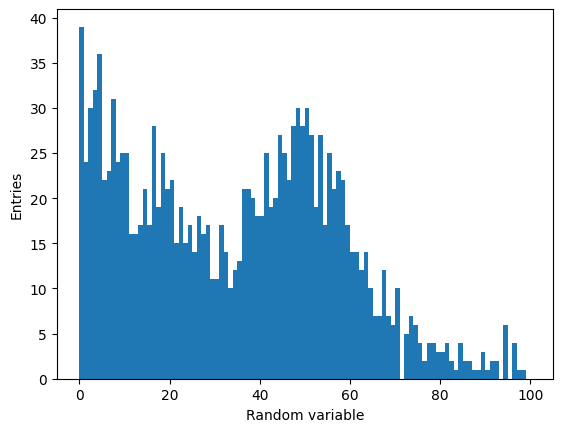

In [ ]:
slope = 30
mean = 50
sigma = 10
n_bkg = 1000
n_sig = 500

sig = np.random.normal(mean, sigma, n_sig)
bkg = - slope * np.log (np.random.uniform(0, 1, n_bkg))

dataset = np.concatenate((sig, bkg))

bins = np.linspace(0, 100, 101)
plt.hist (dataset, bins=bins)
plt.xlabel("Random variable"); plt.ylabel("Entries")
plt.show()

## Definition of the fit model as a Python class

As we have discussed when considering `iminuit` as an optimization tool, we aim at a loss function depending only on the free parameters of the optimization, but the likelihood clearly depends on the dataset as well!

There are several ways to achieve this, the simples option is probably to store the dataset in a global variable. However this is often not practical, because we may want to compute the likelihood for different datasets and this would imply modifying the shared global variable holding the dataset prior of each function call. That's a recipe for a disaster...

A better solution is defining the model in a class acquiring the dataset at initialization. In this way we can have multiple instances, one per dataset, replicating the same model, and exposing a method `nll` for the negative log-likelihood depending only on the parameters.

> **Reminder.** The decorator `@staticmethod` identifies methods that do not depend on any class-internal data nor method, while `@classmethod` identifies methods that have no access to the instance data, but can access to class methods.
> In this case, we will define two *static* methods for `signal` and `background`, and a *class* method combining the two.








In [ ]:
class FitModel:
  def __init__(self, dataset):
    self._dataset = dataset

  @staticmethod
  def signal(x, mean, sigma):
    return 1/np.sqrt(2*np.pi*sigma**2) * np.exp(-0.5*((x - mean)/sigma)**2 )

  @staticmethod
  def background(x, slope):
    return 1/slope * np.exp(-x/slope)

  @classmethod
  def pdf(cls, x, mean, sigma, slope, n_sig, n_bkg):
    f = n_sig / (n_sig + n_bkg)
    return f * cls.signal(x, mean, sigma) + (1-f) * cls.background(x, slope)

  def nll(self, mean, sigma, slope, n_sig, n_bkg):
    return -np.sum(np.log(self.pdf(self._dataset, mean, sigma, slope, n_sig, n_bkg)))

## Plotting the model

When plotting the model we should remember that it is normalized.

If we want to compare it to the histogram, we should compute the expected number of entries in a bin. If we assume bins sufficiently small that the pdf is constant, we can write that the probability for an entry to fall between $y$ and $y + \Delta y$ is

$$
P(y < Y < y+\Delta y) = p(y) \Delta y
$$

the probability can be multiplied for the total number of events to estimate the yield expected between $y$ and $y + \Delta y$.

$$
N_i =  N_\mathrm{tot}\, p(y_i)\, \Delta y_i
$$


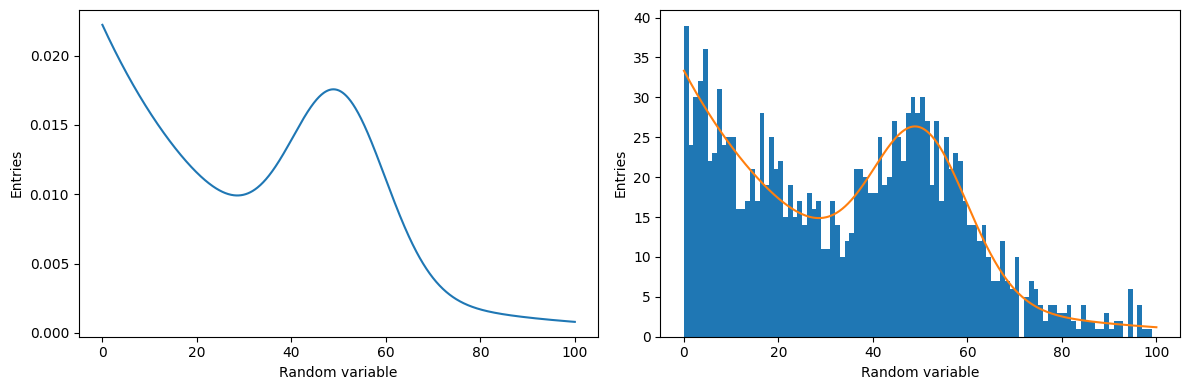

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
x_axis = np.linspace(0, 100, 1000)
plt.plot(x_axis, FitModel.pdf(x_axis, mean=mean, sigma=sigma, slope=slope, n_sig=n_sig, n_bkg=n_bkg))
plt.xlabel("Random variable"); plt.ylabel("Entries")


plt.subplot(1, 2, 2)
bins = np.linspace(0, 100, 101)
plt.hist (dataset, bins=bins)
plt.xlabel("Random variable"); plt.ylabel("Entries")
bin_width = (bins[-1] - bins[0])/(len(bins) - 1)

x_axis = np.linspace(0, 100, 1000)
plt.plot(x_axis, (n_sig+n_bkg)*bin_width * FitModel.pdf(x_axis, mean=mean, sigma=sigma, slope=slope, n_sig=n_sig, n_bkg=n_bkg))

plt.tight_layout()
plt.show()

## Optimization with Minuit

As customary, let's pass to Minuit the function to minimize.
This time, we will pass it as a method of an instance holding our dataset:
```python
FitModel(dataset).nll
```

Note that we are passing a function as an argument.

In [ ]:
from iminuit import Minuit

m = Minuit(FitModel(dataset).nll, mean=mean, sigma=sigma, slope=slope, n_sig=n_sig, n_bkg=n_bkg)
m.errordef = 0.5

m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 6697                       │              Nfcn = 104              │
│ EDM = 1.47e-05 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mean  │   50.8    │    0.7    │            │            │         │         │       │
│ 1 │ sigma │    9.8    │    0.7    │            │            │         │         │       │
│ 2 │ slope │   29.7    │    1.1    │            │            │         │         │       │
│ 3 │ n_sig │   0.5e3   │   0.4e3   │            │            │         │         │       │
│ 4 │ n_bkg │   1.0e3   │   0.9e3   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬──────────────────────────────────────────────┐
│       │     mean    sigma    slope    n_sig    n_bkg │
├───────┼──────────────────────────────────────────────┤
│  mean │    0.471     -0.1     -0.0     -7.2     -0.9 │
│ sigma │     -0.1    0.517     -0.2     18.2     -1.5 │
│ slope │     -0.0     -0.2     1.15    -11.5     15.7 │
│ n_sig │     -7.2     18.2    -11.5 1.68e+05   0.35e6 │
│ n_bkg │     -0.9     -1.5     15.7   0.35e6  7.3e+05 │
└───────┴──────────────────────────────────────────────┘

Note the **very high correlation** between `n_sig` and `n_bkg`. This is expected: our model only depends on the their relative values, so identical results can be obtained if the number of signal and background events changes proportionally.

We can then plot the result.

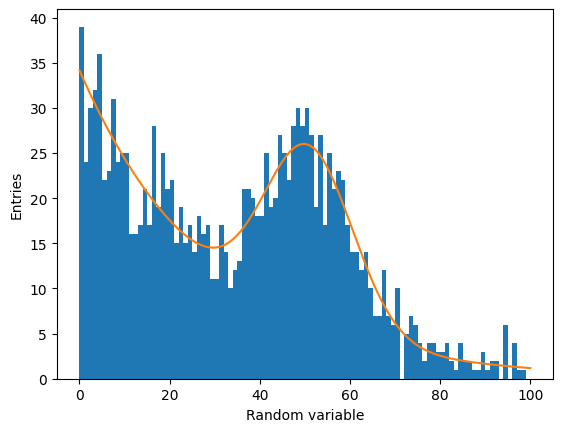

In [ ]:
bins = np.linspace(0, 100, 101)
plt.hist (dataset, bins=bins)
plt.xlabel("Random variable"); plt.ylabel("Entries")
bin_width = (bins[-1] - bins[0])/(len(bins) - 1)

x_axis = np.linspace(0, 100, 1000)
plt.plot(x_axis, (n_sig+n_bkg)*bin_width * FitModel.pdf(x_axis, **m.values.to_dict()))

plt.show()

## Extended Likelihood

If we aim at a model constraining the total number of events, we should add a term to our likelihood with the probability of observing $N_\mathrm{tot}$ events.

$$
\mathcal L(\theta) = P(N_{tot} | \vec \theta) \prod_i p(\vec y_i | \vec \theta)
$$

If we assume the probability of observing $N_{tot}$ events is driven by a Poisson distribution
$$
P(N_{\mathrm{tot}}) = \frac{\lambda(\vec \theta)^{N_{\rm tot}}\  e^{-\lambda(\vec \theta)}}{N_{\mathrm{tot}}!}
$$
where $\lambda(\vec \theta)$ is the expected yield.

Considering this new contribution, the negative log-likelihood will become
$$
-\log \mathcal L (\vec \theta) = - \log\left[\lambda(\vec \theta)^{N_{\rm tot}}e^{-\lambda(\vec\theta)} / N_{tot}! \right] \sum_{i=1}^{N_{\rm tot}} \log \left[ p(y_i | \vec \theta) \right]
$$
considering that $\log(ab) = \log(a) + \log(b)$
$$
-\log \mathcal L (\vec \theta) = - N_{\rm tot} \log(\lambda(\vec \theta))  -\lambda(\vec\theta) + \log( N_{tot}! )  - \sum_{i=1}^{N_{\rm tot}} \log \left[ p(y_i | \vec \theta) \right]
$$

The term $\log(N_{tot}!)$ is irrelevant to the minimization as it does not depend on $\vec \theta$. We can also rewrite
$$N_{tot} \log(\lambda(\vec \theta)) = \sum_i \log(\lambda(\vec \theta))$$
so that

$$
-\log \mathcal L (\vec \theta) = \lambda(\vec\theta) - \sum_{i=1}^{N_{\rm tot}} \left[ \log(\lambda(\vec \theta))  + \log \left[ p(y_i | \vec \theta) \right]\right]
$$

or
$$
\boxed{
-\log \mathcal L (\vec \theta) = \lambda(\vec\theta) - \sum_{i=1}^{N_{\rm tot}}  \log \left[ \lambda(\vec \theta) p(y_i | \vec \theta) \right]
}
$$

This expression is known as **extended likelihood**.

---

In the case of the fit of a dataset including a signal and a background the numbers $N_{\rm sig}$ and $N_{\rm bkg}$ representing the yields of the signal and background components are components of the parameter vector $\theta$,
and $\lambda(\vec(\theta))$ is simply
$$
\lambda(\vec(\theta)) = \lambda(N_{\rm sig}, N_{\rm bkg}, \dots) = N_{\rm sig} + N_{\rm bkg}
$$

Therefore,
$$
-\log \mathcal L (\vec \theta) = N_{\rm sig} + N_{\rm bkg} - \sum_{i=1}^{N_{\rm tot}}  \log \left[ (N_{\rm sig} + N_{\rm bkg})\ p(y_i | \vec \theta) \right]
$$

We can therefore rewrite it the `nll` function as
```python
  def nll(self, mean, sigma, slope, n_sig, n_bkg):
    p_y_theta = self.pdf(self._dataset, mean, sigma, slope, n_sig, n_bkg)
    return n_sig + n_bkg - np.sum(np.log((n_sig + n_bkg) * p_y_theta))

```

Instead of rewriting the whole model, let's revise inheritance overriding the `nll` function of the base `FitModel` class:

In [ ]:
class FitModelExt(FitModel):
  def nll(self, mean, sigma, slope, n_sig, n_bkg):
    p_y_theta = self.pdf(self._dataset, mean, sigma, slope, n_sig, n_bkg)
    return n_sig + n_bkg - np.sum(np.log((n_sig + n_bkg) * p_y_theta))


m = Minuit(FitModelExt(dataset).nll, mean=mean, sigma=sigma, slope=slope, n_sig=n_sig, n_bkg=n_bkg)
m.errordef = 0.5

m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -2772                      │              Nfcn = 100              │
│ EDM = 1.41e-05 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mean  │   50.8    │    0.7    │            │            │         │         │       │
│ 1 │ sigma │    9.8    │    0.7    │            │            │         │         │       │
│ 2 │ slope │   29.7    │    1.1    │            │            │         │         │       │
│ 3 │ n_sig │    486    │    35     │            │            │         │         │       │
│ 4 │ n_bkg │  1.01e3   │  0.04e3   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬──────────────────────────────────────────────┐
│       │     mean    sigma    slope    n_sig    n_bkg │
├───────┼──────────────────────────────────────────────┤
│  mean │    0.471     -0.1     -0.0     -4.5      4.5 │
│ sigma │     -0.1    0.518     -0.2     12.7    -12.7 │
│ slope │     -0.0     -0.2     1.15    -12.8     12.8 │
│ n_sig │     -4.5     12.7    -12.8 1.21e+03   -0.7e3 │
│ n_bkg │      4.5    -12.7     12.8   -0.7e3 1.73e+03 │
└───────┴──────────────────────────────────────────────┘

## Scan

Using `iminuit` we can perform a scan of the likelihood with respect to one (or two) parameters.
The likelihood scan is not used to estimate the uncertainty on the results of the fit, the second derivative of the negative log likelihood in the mimium is used instead.

However, in the case we are considering, the profile likelihood of the standard deviation $\sigma$ is slightly asymmetric. We can use the MINOS algorithm to assign the (possibly asymmetrics) uncertainty intervals to the fit results using likelihood scans.

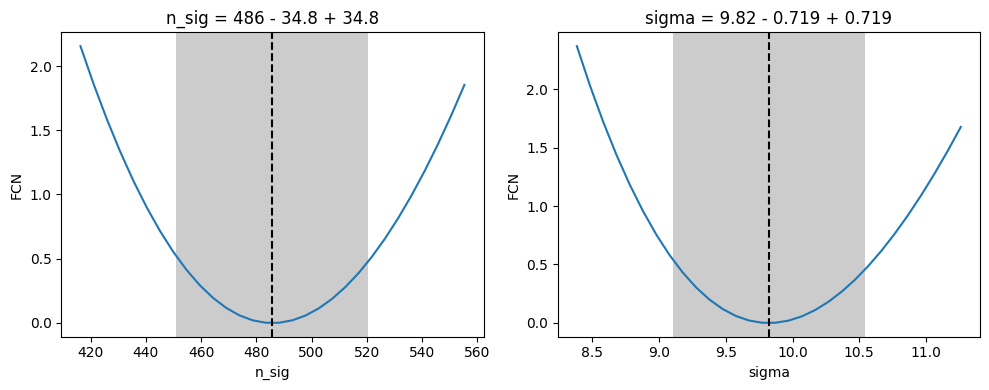

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -2772                      │             Nfcn = 1951              │
│ EDM = 6.16e-10 (Goal: 0.0001)    │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mean  │   50.8    │    0.7    │    -0.7    │    0.7     │         │         │       │
│ 1 │ sigma │    9.8    │    0.7    │    -0.7    │    0.8     │         │         │       │
│ 2 │ slope │   29.7    │    1.1    │    -1.1    │    1.1     │         │         │       │
│ 3 │ n_sig │    486    │    35     │    -34     │     35     │         │         │       │
│ 4 │ n_bkg │  1.01e3   │  0.04e3   │  -0.04e3   │   0.04e3   │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │         mean          │         sigma         │         slope         │         n_sig         │         n_bkg         │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │   -0.7    │    0.7    │   -0.7    │    0.8    │   -1.1    │    1.1    │    -34    │    35     │    -40    │    40     │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌───────┬──────────────────────────────────────────────┐
│       │     mean    sigma    slope    n_sig    n_bkg │
├───────┼──────────────────────────────────────────────┤
│  mean │    0.471     -0.1     -0.0     -4.6      4.5 │
│ sigma │     -0.1    0.517     -0.2     12.8    -12.7 │
│ slope │     -0.0     -0.2     1.15    -12.7     12.8 │
│ n_sig │     -4.6     12.8    -12.7 1.21e+03   -0.7e3 │
│ n_bkg │      4.5    -12.7     12.8   -0.7e3 1.73e+03 │
└───────┴──────────────────────────────────────────────┘

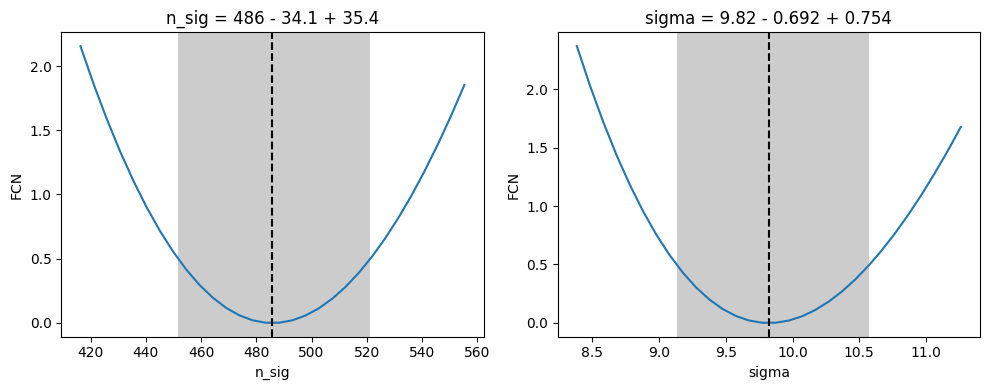

In [ ]:
m.migrad()

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
m.draw_mnprofile('n_sig')

plt.subplot(1, 2, 2)
m.draw_mnprofile('sigma')

plt.tight_layout()
plt.show()

## Let's use the MINOS algorithm
display(m.minos())

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
m.draw_mnprofile('n_sig')

plt.subplot(1, 2, 2)
m.draw_mnprofile('sigma')

plt.tight_layout()
plt.show()

## Numerical normalization

The fit model we have discussed so far relies on the analytical normalization of the probability density functions.
However, both for the normal and the exponential distributions, the analytical normalization is computed on the pdf domain: $\mathbb R$ and $\mathbb R^+$, respectively. This is a very uncommon condition, as most of the time the datasets are selected in well defined intervals.

If the dataset is limited to an interval, the normalization of the pdf should be computed on that interval, not on the whole domain.
For the exponential *pdf*, we could work out an analytical normalization in a range, also for the Gaussian pdf, we could build up something with the error function, but here we will discuss a generic solution based on numerical integration of the pdf.





In [ ]:
class FitModelWithRange:
  def __init__(self, dataset, range):
    self._dataset = dataset[(dataset > range[0]) & (dataset < range[1])]
    self._x_axis = np.linspace(range[0], range[1], 1000)

  @staticmethod
  def _signal(x, mean, sigma):
    return 1/np.sqrt(2*np.pi*sigma**2) * np.exp(-0.5*((x - mean)/sigma)**2 )

  def signal(self, x, mean, sigma):
    norm = np.trapezoid(self._signal(self._x_axis, mean, sigma), self._x_axis)
    return self._signal(x, mean, sigma) / norm

  @staticmethod
  def _background(x, slope):
    return np.exp(-x/slope)

  def background(self, x, slope):
    norm = np.trapezoid(self._background(self._x_axis, slope), self._x_axis)
    return self._background(x, slope) / norm

  def pdf(self, x, mean, sigma, slope, n_sig, n_bkg):
    f = n_sig / (n_sig + n_bkg)
    return f * self.signal(x, mean, sigma) + (1-f) * self.background(x, slope)

  def nll(self, mean, sigma, slope, n_sig, n_bkg):
    return (n_sig + n_bkg) - np.sum(np.log((n_sig + n_bkg) * self.pdf(self._dataset, mean, sigma, slope, n_sig, n_bkg)))


m = Minuit(FitModelWithRange(dataset, range=(0, 100)).nll, mean=mean, sigma=sigma, slope=slope, n_sig=n_sig, n_bkg=n_bkg)
m.errordef = 0.5

m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -2832                      │              Nfcn = 126              │
│ EDM = 2.02e-05 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mean  │   50.6    │    0.7    │            │            │         │         │       │
│ 1 │ sigma │    7.9    │    0.6    │            │            │         │         │       │
│ 2 │ slope │   42.9    │    2.5    │            │            │         │         │       │
│ 3 │ n_sig │    357    │    33     │            │            │         │         │       │
│ 4 │ n_bkg │  1.14e3   │  0.04e3   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬──────────────────────────────────────────────┐
│       │     mean    sigma    slope    n_sig    n_bkg │
├───────┼──────────────────────────────────────────────┤
│  mean │    0.489     -0.0     -0.2     -2.1      2.1 │
│ sigma │     -0.0    0.398     -0.4      9.7     -9.7 │
│ slope │     -0.2     -0.4     6.12      -30       30 │
│ n_sig │     -2.1      9.7      -30 1.06e+03   -0.7e3 │
│ n_bkg │      2.1     -9.7       30   -0.7e3 1.84e+03 │
└───────┴──────────────────────────────────────────────┘

## Advanced: numerical normalization with a decorator

The operations we have performed above to normalize the pdf are symmetrical for the signal and the background component.

We can rewrite the normalization logics as a decortor (a function taking a function as input and returning a modified version of the function).

The logics of the decorator will be:
 * take a function `f(x, *parameters)` as an input;
 * define a new function that compute the integral of `f` in an interval stored as a property of the instance (*e.g.* in the form of an integration axis `self._x_axis`) and returns the original function `f` divided by its norm;


In [ ]:
def numerically_normalized(f):
  def _ret(self, x, *args, **kwargs):
    norm = np.trapezoid(f(self._x_axis, *args, **kwargs), self._x_axis)
    return f(x, *args, **kwargs)  / norm
  return _ret

Then we can rewrite the class defining the model, using this decorator for numerical integration.

In [ ]:
class FitModelWithRange:
  def __init__(self, dataset, range):
    self._dataset = dataset
    self._x_axis = np.linspace(range[0], range[1], 1000)

  @numerically_normalized
  def signal(x, mean, sigma):
    return 1/np.sqrt(2*np.pi*sigma**2) * np.exp(-0.5*((x - mean)/sigma)**2 )

  @numerically_normalized
  def background(x, slope):
    return np.exp(-x/slope)

  def pdf(self, x, mean, sigma, slope, n_sig, n_bkg):
    f = n_sig / (n_sig + n_bkg)
    return f * self.signal(x, mean, sigma) + (1-f) * self.background(x, slope)

  def nll(self, mean, sigma, slope, n_sig, n_bkg):
    return (n_sig + n_bkg) - np.sum(np.log((n_sig + n_bkg) * self.pdf(self._dataset, mean, sigma, slope, n_sig, n_bkg)))


m = Minuit(FitModelWithRange(dataset, range=(0, 100)).nll, mean=mean, sigma=sigma, slope=slope, n_sig=n_sig, n_bkg=n_bkg)
m.errordef = 0.5

m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -2832                      │              Nfcn = 126              │
│ EDM = 2.02e-05 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mean  │   50.6    │    0.7    │            │            │         │         │       │
│ 1 │ sigma │    7.9    │    0.6    │            │            │         │         │       │
│ 2 │ slope │   42.9    │    2.5    │            │            │         │         │       │
│ 3 │ n_sig │    357    │    33     │            │            │         │         │       │
│ 4 │ n_bkg │  1.14e3   │  0.04e3   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬──────────────────────────────────────────────┐
│       │     mean    sigma    slope    n_sig    n_bkg │
├───────┼──────────────────────────────────────────────┤
│  mean │    0.489     -0.0     -0.2     -2.1      2.1 │
│ sigma │     -0.0    0.398     -0.4      9.7     -9.7 │
│ slope │     -0.2     -0.4     6.12      -30       30 │
│ n_sig │     -2.1      9.7      -30 1.06e+03   -0.7e3 │
│ n_bkg │      2.1     -9.7       30   -0.7e3 1.84e+03 │
└───────┴──────────────────────────────────────────────┘

## Conclusion

In this notebook we have discussed the *maximum likelihood fits* or the task of *parametric density estimation*.

We have used iminuit to implement the numerical optimization of the likelihood for a pdf defined as a function of the free parameters $\vec \theta$, then we applied the method to the fit of a distribution of a peak over an exponential background, introducing the uncertainty estimation methods based on the second derivative and on the likelihood scan.

Finally, we have extended the likelihood to take into account the statistical Poisson fluctuations on the total number of observations and introducing the numerical normalization of the probability density function, which is particularly relevant for modelling data in a defined interval.

In the real life, most of these operations are performed with fit frameworks as RooFit, but it is very important to have clear the underlying maths, and have the tool set to cross-check results with independent implementations.
